In [2]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_algorithms.optimizers import COBYLA
from qiskit_machine_learning.algorithms.classifiers import VQC
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.utils.loss_functions.loss_functions import Loss
from sklearn.datasets import load_iris
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from qiskit.primitives import StatevectorSampler as Sampler
import os
from term_loss.loss import L1Loss_ERM, L1Loss_TERM, L2Loss_ERM, L2Loss_TERM, CrossEntropyLoss_ERM, CrossEntropyLoss_TERM

In [8]:
iris_data = load_iris()
features = iris_data.data
labels = iris_data.target
features = MinMaxScaler().fit_transform(features)
df = pd.DataFrame(iris_data.data, columns=iris_data.feature_names)
df["class"] = pd.Series(iris_data.target)
random_seed = 123
train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, train_size=0.8, random_state=random_seed, shuffle=True, stratify=labels
)

In [9]:
iris_data = load_iris()
features = iris_data.data
labels = iris_data.target
features = MinMaxScaler(feature_range=(-np.pi, np.pi)).fit_transform(features)
train_index_total = pd.read_excel("data/train_index_total.xlsx", header=None).to_numpy()
test_index_total = pd.read_excel("data/test_index_total.xlsx", header=None).to_numpy()
split = 1
train_index = train_index_total[:, split - 1]
test_index = test_index_total[:, split - 1]
train_features = features[train_index]
train_labels = labels[train_index]
test_features = features[test_index]
test_labels = labels[test_index]

In [27]:
num_features = features.shape[1]
num_qubits = num_features
feature_reps = 1
ansatz_reps = 9
maxiter = 1000
t = 10
# feature_map = ZZFeatureMap(feature_dimension=num_features, reps=feature_reps)
feature_map = RealAmplitudes(num_qubits=num_qubits, entanglement="linear", parameter_prefix='x', reps=feature_reps, skip_final_rotation_layer=True)
ansatz = RealAmplitudes(num_qubits=num_features, reps=ansatz_reps, entanglement='linear', skip_final_rotation_layer=True)

# callback function that draws a live plot when the .fit() method is called
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

# construct neural network classifier
vqc = VQC(
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=COBYLA(maxiter=maxiter),
    callback=callback_graph,
    loss = CrossEntropyLoss_TERM(t=t),
    initial_point = np.random.rand(ansatz.num_parameters)
)

# newpath = f'/Users/choyboy/Documents/Python/QML/term/cross_entropy_erm'
# if not os.path.exists(newpath):
#     os.makedirs(newpath)

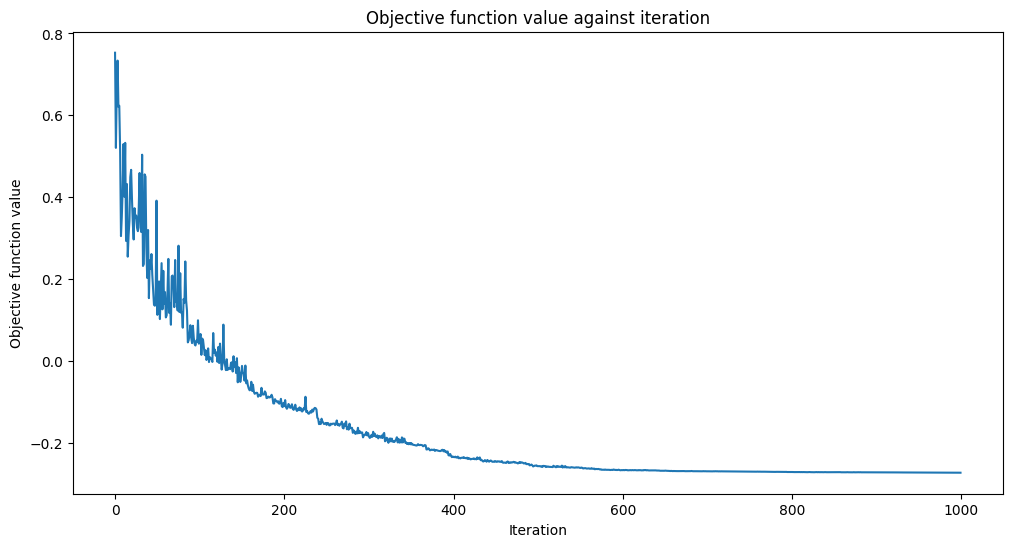

Train accuracy: 0.975
Test accuracy: 0.8666666666666667


In [28]:
# clear objective value history
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to training data
vqc.fit(train_features, train_labels)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score classifier
train_score = vqc.score(train_features, train_labels)
test_score = vqc.score(test_features, test_labels)
print(f"Train accuracy: {train_score}")
print(f"Test accuracy: {test_score}")

# save the model
# vqc.save(f'{newpath}/ra_a{ansatz_reps}_m{maxiter}')